# Size density analysis

In the preliminary analysis, we found that some factors had a much higher impact on the performances than others. For instance, compiling with GCC optimizations has a great impact.

We will now study the performances of roaring bitmap for various sizes and densities.

The command used to get the results is given for each dataset. This is a Python script that runs the experiments with the given parameters and outputs the results in the given CSV file.

It can takes the options `--amalg`, `--gcc`, `--avx`, `--cow` and `--run` which respectively enable amalgamation, GCC optimization, AVX optimization, copy on write and run containers optimization. Each of these options also come with its opposite (for an option `--foo`, there is an option `--no-foo`).

The size of the roaring bitmaps are given by the arguments `--size1` and `--size2`, their densities by the arguments `--density1` and `--density2`. Sizes are integers, densities are floats.
These arguments can be a single value (e.g. `--size1 27`), a list of values (e.g. `--size1 32,64,128,256`) or a range of values (e.g. `--size1 1:1000`).
The value actually used for each experiment is sampled randomly and uniformly in the given list (resp. range).

The argument `--size2` (resp. `--density2`) can be omitted. In this case, the random value used for each experiment will be exactly the same than the one used for the first size (resp. the first density). In this case, the two sizes (resp. densities) are therefore not independent anymore.

In [1]:
library(ggplot2)

Our first experiment is simple.

These results have been obtained with the following command:
```bash
export LD_LIBRARY_PATH="`pwd`/build/:$LD_LIBRARY_PATH"
./scripts/size_density_runner.py --amalg --gcc --avx --cow --run\
    --size1 1:10000000 --size2 1:10000000\
    --density1 0.5 --density2 0.5 -n 100\
    results/size_results_cow_0.5.csv
```

Size of the two roaring bitmaps are sampled randomly and uniformly in [0, 10^7], their densities is 0.5, all optimizations are enabled.

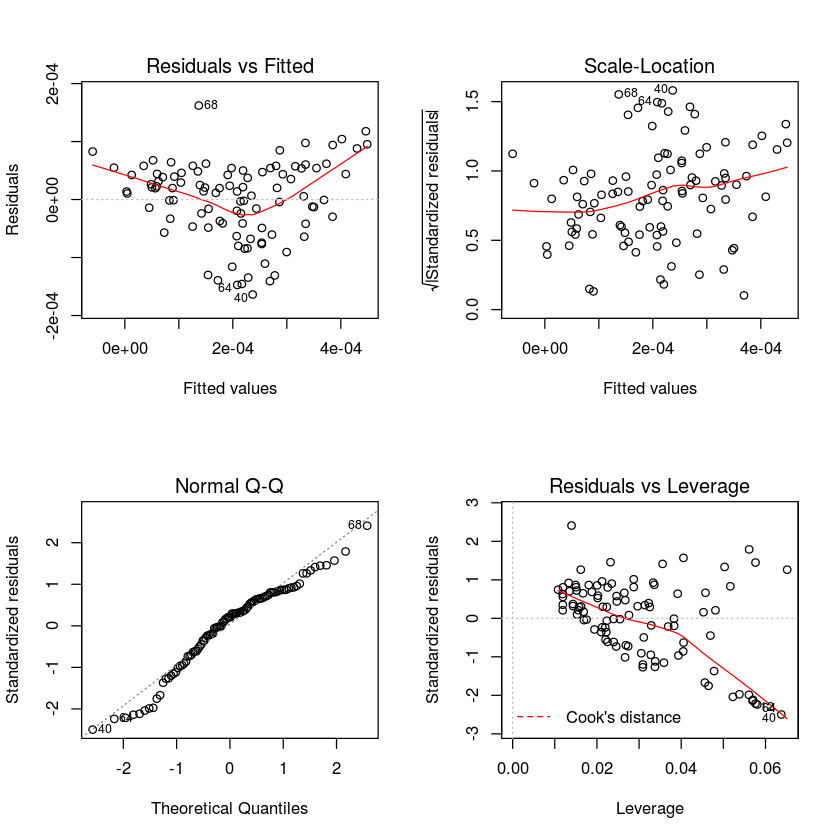

In [2]:
results_basic <- read.csv("results/old_size_results_cow_0.5.csv")
reg_basic <- lm(time~size1+size2, data=results_basic)
layout(matrix(c(1,2,3,4),2,2))
plot(reg_basic)

In [3]:
summary(reg_basic)


Call:
lm(formula = time ~ size1 + size2, data = results_basic)

Residuals:
       Min         1Q     Median         3Q        Max 
-1.638e-04 -4.134e-05  1.408e-05  4.759e-05  1.621e-04 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -7.873e-05  1.835e-05  -4.289 4.24e-05 ***
size1        2.657e-11  2.415e-12  11.005  < 2e-16 ***
size2        3.075e-11  2.522e-12  12.194  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6.775e-05 on 97 degrees of freedom
Multiple R-squared:  0.741,	Adjusted R-squared:  0.7357 
F-statistic: 138.8 on 2 and 97 DF,  p-value: < 2.2e-16


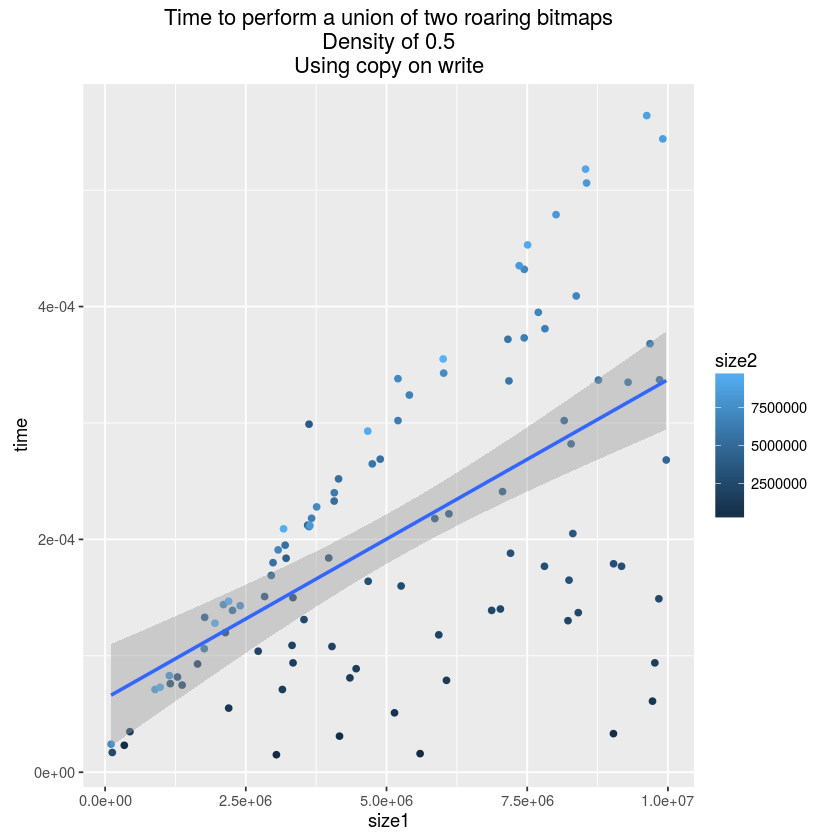

In [4]:
ggplot(results_basic, aes(x=size1, y=time, color=size2))+
    geom_point() + geom_smooth(method=lm) +
    ggtitle("Time to perform a union of two roaring bitmaps\nDensity of 0.5\nUsing copy on write")

Unfortunately, it is clearly heteroscedastic.

Hypothesis: it comes from the copy on write. Indeed, when taking the union, some of the containers may be identical to one container of the two bitmaps (if the other bitmap has no elements for the corresponding key). In this case, the container is not truly copied, the result has only a reference to the original container, which is much faster. This would therefore yield to huge performance gaps, in comparison with other experiments with similar sizes where most of the containers were written and thus truly copied.

Let's try without copy on write!

These new results have been obtained with the following command:
```bash
./scripts/size_density_runner.py --amalg --gcc --avx --no-cow --run\
    --size1 1:10000000 --size2 1:10000000\
    --density1 0.5 --density2 0.5 -n 100\
    results/size_results_no_cow_0.5.csv
```

Size of the two roaring bitmaps are sampled randomly and uniformly in [0, 10^7], their densities is 0.5, all optimizations are enabled except copy on write.

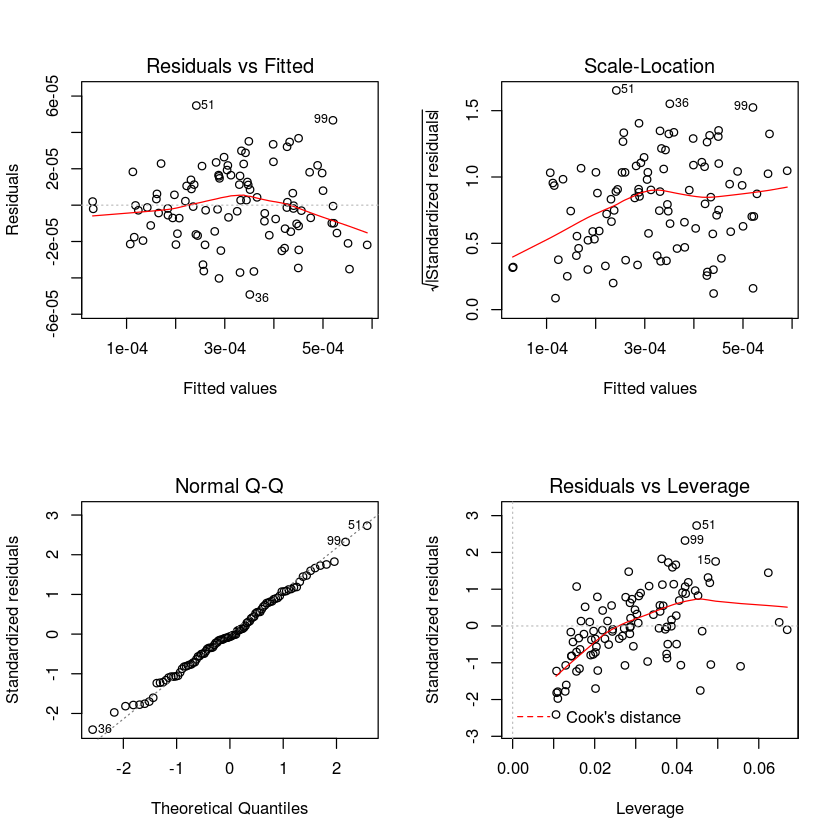

In [5]:
results_no_cow <- read.csv("results/old_size_results_no_cow_0.5.csv")
reg_no_cow <- lm(time~size1+size2, data=results_no_cow)
layout(matrix(c(1,2,3,4),2,2))
plot(reg_no_cow)

In [6]:
summary(reg_no_cow)


Call:
lm(formula = time ~ size1 + size2, data = results_no_cow)

Residuals:
       Min         1Q     Median         3Q        Max 
-4.916e-05 -1.448e-05 -1.304e-06  1.501e-05  5.478e-05 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 7.415e-07  5.715e-06    0.13    0.897    
size1       2.900e-11  7.474e-13   38.80   <2e-16 ***
size2       3.430e-11  6.906e-13   49.67   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.053e-05 on 97 degrees of freedom
Multiple R-squared:  0.9747,	Adjusted R-squared:  0.9742 
F-statistic:  1868 on 2 and 97 DF,  p-value: < 2.2e-16


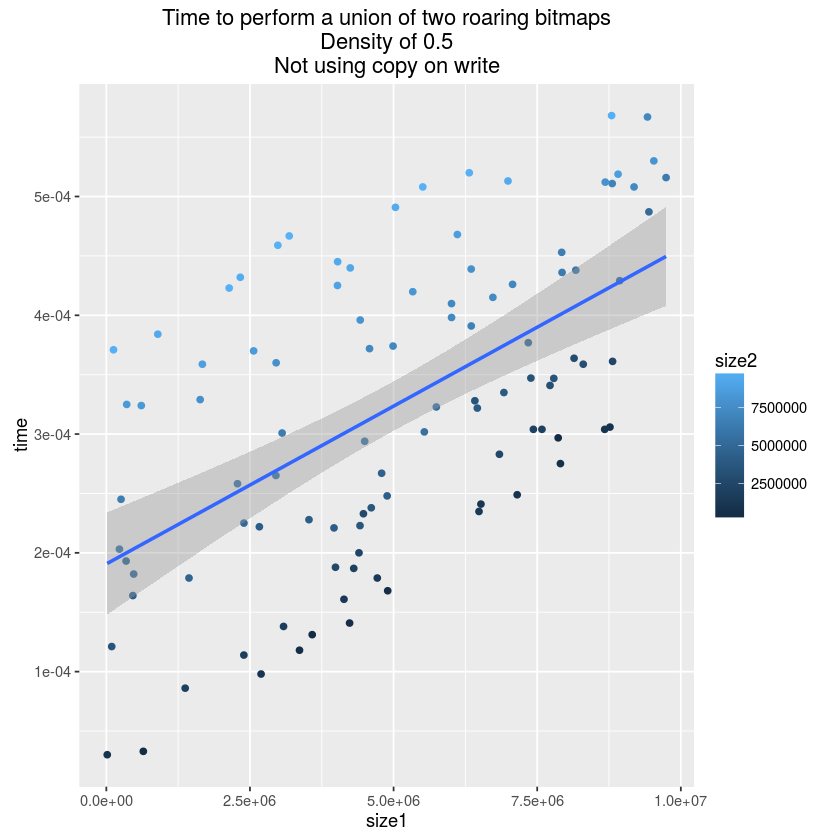

In [7]:
ggplot(results_no_cow, aes(x=size1, y=time, color=size2))+
    geom_point() + geom_smooth(method=lm) +
    ggtitle("Time to perform a union of two roaring bitmaps\nDensity of 0.5\nNot using copy on write")

There results seems to be better, they look homoscedastic. But there is still a lot of noise, that is clearly due to the fact that the time also depends on `size2` and not only on `size1`.

We should try to agglomerate these two variables into a single one: let us take the sum.

In [8]:
results_no_cow$size_sum <- apply(results_no_cow[,c('size1','size2')], 1, function(y) sum(y['size1'],y['size2'])) # can also take the max

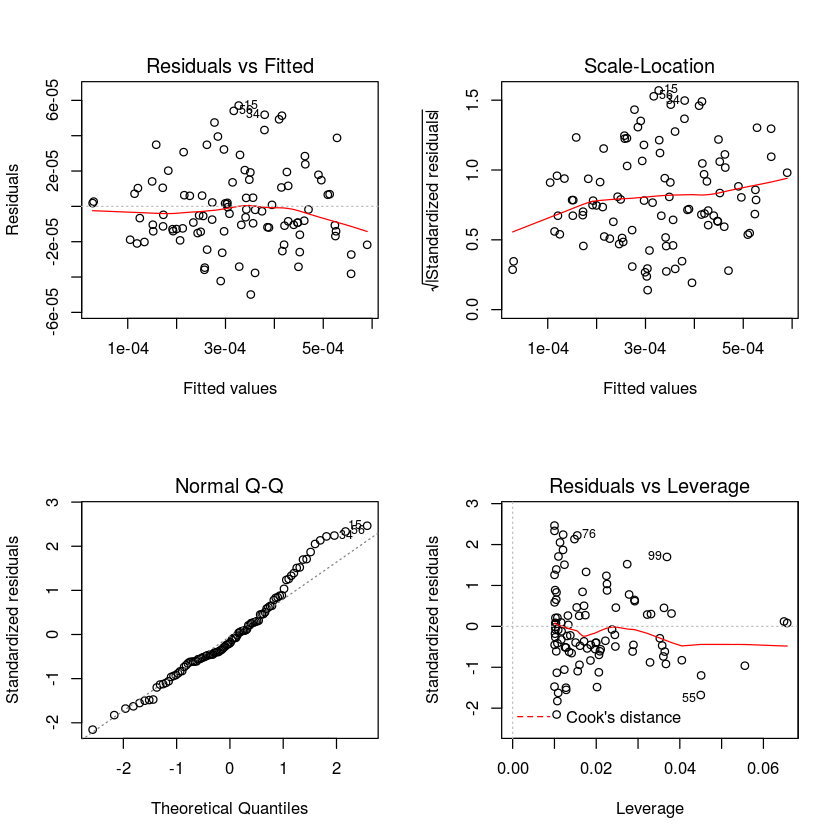

In [9]:
reg_no_cow2 <- lm(time~size_sum, data=results_no_cow)
layout(matrix(c(1,2,3,4),2,2))
plot(reg_no_cow2)

In [10]:
summary(reg_no_cow2)


Call:
lm(formula = time ~ size_sum, data = results_no_cow)

Residuals:
       Min         1Q     Median         3Q        Max 
-4.990e-05 -1.410e-05 -4.468e-06  1.211e-05  5.707e-05 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.006e-06  6.469e-06  -0.156    0.877    
size_sum     3.188e-11  5.936e-13  53.698   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.327e-05 on 98 degrees of freedom
Multiple R-squared:  0.9671,	Adjusted R-squared:  0.9668 
F-statistic:  2883 on 1 and 98 DF,  p-value: < 2.2e-16


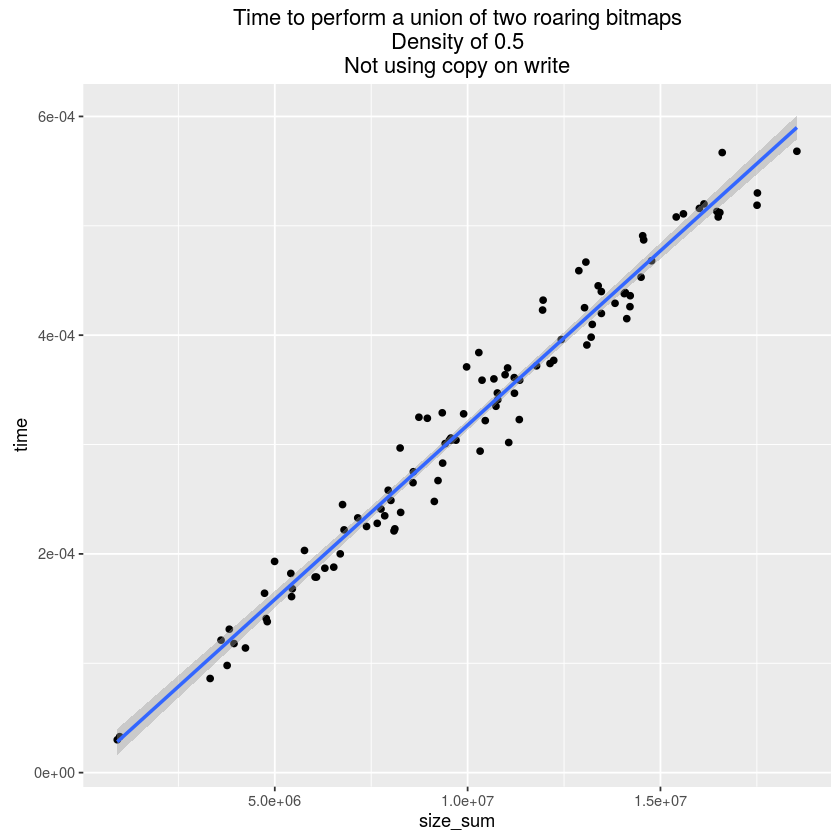

In [11]:
ggplot(results_no_cow, aes(x=size_sum, y=time))+
    geom_point() + geom_smooth(method=lm) +
    ggtitle("Time to perform a union of two roaring bitmaps\nDensity of 0.5\nNot using copy on write")

The plot still looks great, but with much less noise.

We will now consider the impact of density.

The following results have been obtained with the command:
```bash
./scripts/size_density_runner.py --amalg --gcc --avx --no-cow --run\
    --size1 1:40000000 --size2 1:40000000\
    --density1 0.01,0.04,0.1,0.5,0.999\
    -n 434 results/size_density_results.csv # long, about 6h30 to run...
```

Size of the two roaring bitmaps are sampled randomly and uniformly in [0, 4*10^7], a density is sampled randomly and uniformly in {0.01, 0.04, 0.1, 0.5, 0.999} (same density for the two bitmaps), all optimizations are enabled except copy on write.

In [12]:
all_times = read.csv("results/size_density_results.csv")
all_times$density1 <- factor(all_times$density1)
all_times$size_sum <- apply(all_times[,c('size1','size2')], 1, function(y) sum(y['size1'],y['size2'])) # can also take the max

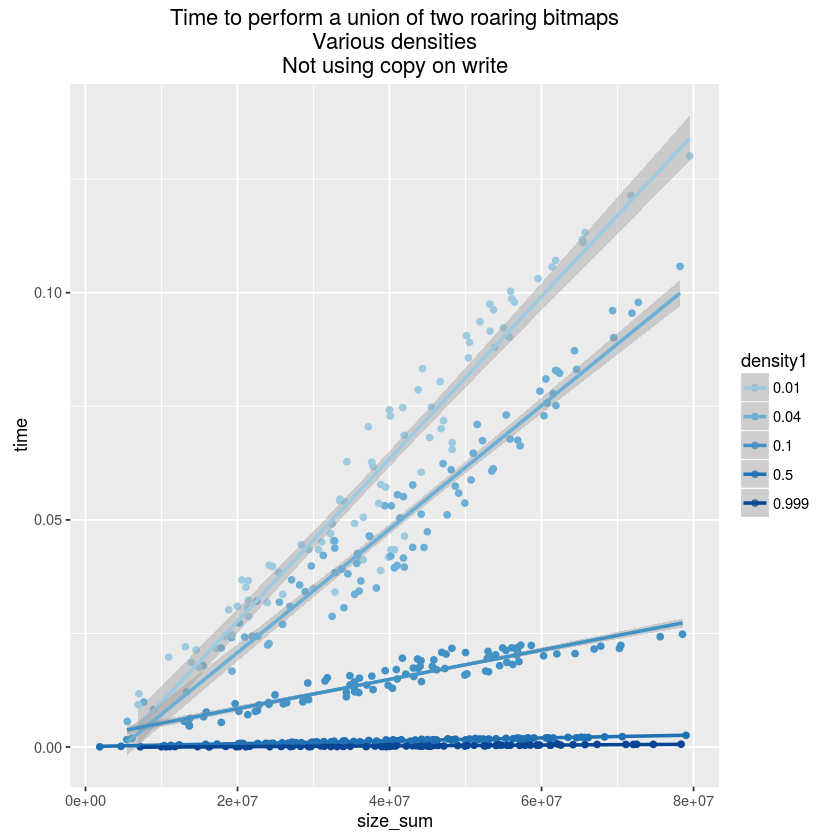

In [13]:
library(RColorBrewer)
my_colors = brewer.pal(n = 7, "Blues")[3:7] # we exclude the lightest colors

ggplot(all_times, aes(x=size_sum, y=time, group=density1, colour=density1))+
            geom_point() + geom_smooth(method=lm) +
            ggtitle("Time to perform a union of two roaring bitmaps\nVarious densities\nNot using copy on write") +
            scale_colour_manual(values=my_colors)
            #scale_color_brewer(type="seq") # alternative, without excluding colors

For clarity, we plot the same graph in log scale.

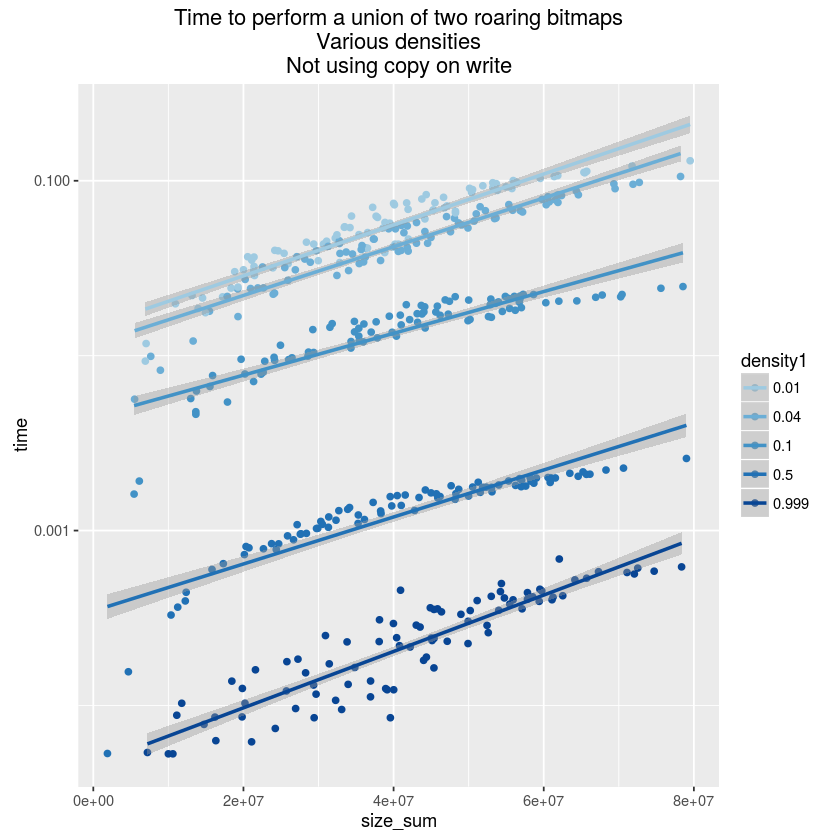

In [14]:
ggplot(all_times, aes(x=size_sum, y=time, group=density1, colour=density1))+
            geom_point() + geom_smooth(method=lm) +
            ggtitle("Time to perform a union of two roaring bitmaps\nVarious densities\nNot using copy on write") +
            scale_colour_manual(values=my_colors) +
            scale_y_log10()

For the record, with Python 3, taking the union of two builtin sets containing 4\*10^7 elements takes roughly 2.3s with a density of 0.5 and 4.8s with a density of 0.01. The memory consumption is also much higher (up to 8GB versus about 750 MB).

In [15]:
for(density in sort(unique(all_times[,'density1']))) {
    print(paste('density =', density))
    print(lm(time~size_sum, data=all_times[all_times['density1'] == density,])$coefficients)
}



[1] "density = 0.01"
  (Intercept)      size_sum 
-7.988125e-03  1.785886e-09 
[1] "density = 0.04"
  (Intercept)      size_sum 
-6.384362e-03  1.358965e-09 
[1] "density = 0.1"
 (Intercept)     size_sum 
2.014159e-03 3.221184e-10 
[1] "density = 0.5"
 (Intercept)     size_sum 
1.076313e-04 3.151404e-11 
[1] "density = 0.999"
  (Intercept)      size_sum 
-9.723984e-05  8.758086e-12 


We see here that the densities of the two roaring bitmaps change a lot the performances. Low densities like 0.01 or 0.04 yield to a union two orders of magnitude slower than high densities like 0.5 or 0.999.

We recall that the transition from array container to bitset container happens when the container holds 2^12 elements. The maximum number of elements is 2^16, so this corresponds to a density of 2^-4 = 0.0625. Therefore, in our experiments, the two lowest densities are more likely to have array (and maybe run) containers whereas the other densities are more likely to have bitset (and maybe run) containers.

Also, bitmaps with lower densities will have a larger number of containers, with less elements per containers.

The overall performances are very good: 0.01ns to 1ns per element.

## Conclusion

Similarly to the preliminary analysis, our first results were not good. Examination of the plots has shown that the variance was not constant, i.e. the results were heteroscedastic.

We found out that this came from the usage of copy on write (COW), which occasionally gave very optimistic results. We therefore disabled this option, to have better results that match more closely the “true performances”. Indeed, one can argue that for performance evaluation, COW is somehow “cheating”, since one may have to pay the cost of the copy later if the result of the union or one of the operands is modified.

Finally, we plotted the time required to take the union as a function of the sum of the bitmaps' sizes, for various densities. This has shown the high performance of this operation as well as the great impact of the densities.